In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd
import bottleneck as bn
from scipy.stats import truncnorm
import pdb
from tqdm import tqdm

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [2]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [3]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ./ml-20m.zip
!mkdir ./data
!mv ./ml-20m ./data

--2020-05-14 12:09:09--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  4.26MB/s    in 35s     

2020-05-14 12:09:44 (5.38 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ./ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
DATA_DIR = './data/ml-20m/'

In [6]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [7]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [8]:
raw_data.sample(10)

,userId,movieId,rating,timestamp
2787190,18871,7323,4.5,1273523160
5713566,39309,1085,4.0,875002043
3509174,23921,91630,4.0,1334961723
18486751,127974,34162,4.0,1172753814
490988,3300,2019,5.0,962681551
7058996,48660,296,4.0,1111750738
3797705,25881,595,4.5,1205509363
3839445,26177,2858,4.0,1168502886
3732622,25409,1263,4.0,1290905482
13683948,94537,2628,4.0,1089714982


In [8]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [9]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [10]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [11]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9990682 watching events from 136677 users and 20720 movies (sparsity: 0.353%)


In [12]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [13]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [14]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [15]:
unique_sid = pd.unique(train_plays['movieId'])

In [16]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [17]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [18]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [19]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [20]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [21]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [22]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [23]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [24]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [25]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [26]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [27]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [28]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

## Model definition and training

In [29]:
def truncated_normal(size, std=1):
    values = truncnorm.rvs(-2.*std, 2.*std, size=size)
    return values

In [30]:
class MultiDAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, random_seed=None):
        super(MultiDAE, self).__init__()
        self.random_seed = random_seed
        
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        dims = self.q_dims + self.p_dims[1:]
        
        l_list = nn.ModuleList([])
        for i in range(len(dims) - 1):
            l_list.append(nn.Linear(dims[i], dims[i + 1]))
            l_list[-1].weight = nn.init.xavier_uniform_(l_list[-1].weight)
            l_list[-1].bias = nn.Parameter(torch.tensor(truncated_normal(l_list[-1].bias.shape, 0.001), dtype=torch.float32))
            l_list.append(nn.Tanh())
        l_list = l_list[:-1]
        
        self.model = nn.Sequential(*l_list)
        self.dropout = nn.Dropout()
        print(self.model)

    def forward(self, x_initial):
#         pdb.set_trace()
        l2 = torch.sum(x_initial**2, 1)[..., None]
        x_normed = x_initial / torch.sqrt(torch.max(l2, torch.ones_like(l2) * 1e-12))
        x = self.dropout(x_normed)
        logits = self.model(x)
        return logits
    
    
    
class MultiVAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, random_seed=None, device="cpu"):
        super(MultiVAE, self).__init__()
#         pdb.set_trace()
        self.random_seed = random_seed
        
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
            q_dims = self.q_dims
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        
        q_list = nn.ModuleList([])
        for i in range(len(q_dims) - 1):
            if i == len(q_dims) - 2:
                q_list.append(nn.Linear(q_dims[i], 2 * q_dims[i + 1])) 
            else:
                q_list.append(nn.Linear(q_dims[i], q_dims[i + 1])) 
            q_list[-1].weight = nn.init.xavier_uniform_(q_list[-1].weight)
            q_list[-1].bias = nn.Parameter(torch.tensor(truncated_normal(q_list[-1].bias.shape, 0.001), dtype=torch.float32))
            q_list.append(nn.Tanh())
        q_list = q_list[:-1]
        self.encoder = nn.Sequential(*q_list)
        print(self.encoder)
        
        p_list = nn.ModuleList([])
        for i in range(len(p_dims) - 1):
            p_list.append(nn.Linear(p_dims[i], p_dims[i + 1])) 
            p_list[-1].weight = nn.init.xavier_uniform_(p_list[-1].weight)
            p_list[-1].bias = nn.Parameter(torch.tensor(truncated_normal(p_list[-1].bias.shape, 0.001), dtype=torch.float32))
            p_list.append(nn.Tanh())
        p_list = p_list[:-1]
        self.decoder = nn.Sequential(*p_list)
        print(self.decoder)
        
        self.dropout = nn.Dropout()
        
        device_zero = torch.tensor(0., dtype=torch.float32, device=device)
        device_one = torch.tensor(1., dtype=torch.float32, device=device)
        self.std_normal = torch.distributions.Normal(loc=device_zero, scale=device_one)
        
        
    def forward(self, x_initial, is_training_ph=1.):
#         pdb.set_trace()
        l2 = torch.sum(x_initial**2, 1)[..., None]
        x_normed = x_initial / torch.sqrt(torch.max(l2, torch.ones_like(l2) * 1e-12))
        x = self.dropout(x_normed)
        
        enc_out = self.encoder(x)
        mu, logvar = enc_out[:, :self.q_dims[-1]], enc_out[:, self.q_dims[-1]:]
        std = torch.exp(0.5 * logvar)
        KL = torch.mean(torch.sum(0.5 * (-logvar + torch.exp(logvar) + mu**2 - 1), dim=1))
        
        u = self.std_normal.sample(mu.shape)
        z = mu + is_training_ph * u * std
        
        logits = self.decoder(z)
        
        return logits, KL

In [31]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [32]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [33]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [34]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [35]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

In [36]:
N = train_data.shape[0]
idxlist = np.arange(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [37]:
n_epochs = 75

## Train MultiDAE

In [38]:
model = MultiDAE([200, n_items]).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01 / batch_size)

Sequential(
  (0): Linear(in_features=20108, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=20108, bias=True)
)


In [39]:
ndcgs_vad = []
best_ndcg = -np.inf
print_info_ = 5

for epoch in tqdm(range(n_epochs)):
    np.random.shuffle(idxlist)
    # train for one epoch
    model.train()
    for bnum, st_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(st_idx + batch_size, N)
        X = train_data[idxlist[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = torch.tensor(X, dtype=torch.float32).to(device)
        logits = model(X)
        log_softmax_var = nn.LogSoftmax(dim=-1)(logits)
        # per-user average negative log-likelihood
        neg_ll = -torch.mean(torch.sum(log_softmax_var * X, dim=1))
        loss = neg_ll
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (bnum % 100 == 0) and (epoch % print_info_ == 0):
            print(loss.cpu().detach().numpy())

    # compute validation NDCG
    model.eval()
    with torch.no_grad():
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = torch.tensor(X, dtype=torch.float32).to(device)
            pred_val = model(X)
            X = X.cpu().detach().numpy()
            pred_val = pred_val.cpu().detach().numpy()
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))

        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            torch.save(model, './best_DAE.pt')
            best_ndcg = ndcg_
        if epoch % print_info_ == 0:
            print('Best NDCG:', best_ndcg)
            print('Current NDCG:', ndcg_)

  0%|          | 0/75 [00:00<?, ?it/s]

723.32587
546.95807
499.66348


/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MultiDAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  1%|▏         | 1/75 [00:09<11:07,  9.02s/it]

Best NDCG: 0.27113253014022587
Current NDCG: 0.27113253014022587


  7%|▋         | 5/75 [00:48<10:51,  9.30s/it]

519.573
450.59003
476.90384


  8%|▊         | 6/75 [00:57<10:35,  9.21s/it]

Best NDCG: 0.39655231279250674
Current NDCG: 0.39655231279250674


 13%|█▎        | 10/75 [01:33<09:45,  9.01s/it]

449.53687
523.9513
497.50815


 15%|█▍        | 11/75 [01:42<09:37,  9.02s/it]

Best NDCG: 0.41368426071202874
Current NDCG: 0.41368426071202874


 20%|██        | 15/75 [02:17<08:57,  8.96s/it]

432.71036
423.92838
483.95215


 21%|██▏       | 16/75 [02:26<08:49,  8.98s/it]

Best NDCG: 0.41783955643867204
Current NDCG: 0.41783955643867204


 27%|██▋       | 20/75 [03:02<08:11,  8.94s/it]

417.60126
502.17447
494.96292


 28%|██▊       | 21/75 [03:11<08:02,  8.93s/it]

Best NDCG: 0.41911463450519293
Current NDCG: 0.41899082005191923


 33%|███▎      | 25/75 [03:47<07:27,  8.95s/it]

494.8671
467.4821
476.4138


 35%|███▍      | 26/75 [03:56<07:19,  8.97s/it]

Best NDCG: 0.4204872657679547
Current NDCG: 0.4204872657679547


 40%|████      | 30/75 [04:32<06:42,  8.95s/it]

491.3055
413.1491
464.48526


 41%|████▏     | 31/75 [04:41<06:33,  8.94s/it]

Best NDCG: 0.4213251613320533
Current NDCG: 0.4206691778763283


 47%|████▋     | 35/75 [05:17<05:59,  9.00s/it]

407.18265
456.96906
475.40903


 48%|████▊     | 36/75 [05:26<05:51,  9.02s/it]

Best NDCG: 0.4224764290717107
Current NDCG: 0.4224764290717107


 53%|█████▎    | 40/75 [06:01<05:13,  8.96s/it]

457.77423
441.20874
490.1089


 55%|█████▍    | 41/75 [06:10<05:04,  8.95s/it]

Best NDCG: 0.4226751621298703
Current NDCG: 0.42257753643099777


 60%|██████    | 45/75 [06:46<04:28,  8.94s/it]

533.3522
509.6663
518.9618


 61%|██████▏   | 46/75 [06:55<04:20,  8.97s/it]

Best NDCG: 0.42277850453382254
Current NDCG: 0.42277850453382254


 67%|██████▋   | 50/75 [07:31<03:44,  8.98s/it]

497.29996
413.58353
427.23764


 68%|██████▊   | 51/75 [07:40<03:36,  9.02s/it]

Best NDCG: 0.42375861668534437
Current NDCG: 0.42375861668534437


 73%|███████▎  | 55/75 [08:16<02:58,  8.95s/it]

460.1631
440.26654
453.02866


 75%|███████▍  | 56/75 [08:25<02:50,  8.95s/it]

Best NDCG: 0.4238839191400252
Current NDCG: 0.4233461808507302


 80%|████████  | 60/75 [09:01<02:14,  8.97s/it]

452.49146
422.33856
466.21872


 81%|████████▏ | 61/75 [09:10<02:05,  8.98s/it]

Best NDCG: 0.4238839191400252
Current NDCG: 0.42374814435007957


 87%|████████▋ | 65/75 [09:46<01:29,  8.98s/it]

486.10117
438.98657
433.34402


 88%|████████▊ | 66/75 [09:55<01:20,  8.97s/it]

Best NDCG: 0.4246563415207782
Current NDCG: 0.4240893123105426


 93%|█████████▎| 70/75 [10:30<00:44,  8.94s/it]

479.9263
458.48965
416.3224


 95%|█████████▍| 71/75 [10:39<00:35,  8.94s/it]

Best NDCG: 0.4246563415207782
Current NDCG: 0.4244241874912417


100%|██████████| 75/75 [11:15<00:00,  9.00s/it]


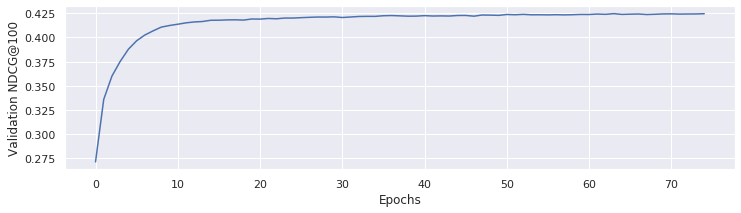

In [40]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### Train MultiVAE

In [41]:
p_dims = [200, 600, n_items]

In [42]:
model_vae = MultiVAE(p_dims, device=device).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), weight_decay=0.)

Sequential(
  (0): Linear(in_features=20108, out_features=600, bias=True)
  (1): Tanh()
  (2): Linear(in_features=600, out_features=400, bias=True)
)
Sequential(
  (0): Linear(in_features=200, out_features=600, bias=True)
  (1): Tanh()
  (2): Linear(in_features=600, out_features=20108, bias=True)
)


In [43]:
ndcgs_vad = []
best_ndcg = -np.inf
print_info_ = 5

update_count = 0.0

for epoch in tqdm(range(n_epochs)):
    np.random.shuffle(idxlist)
    # train for one epoch
    model_vae.train()
    for bnum, st_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(st_idx + batch_size, N)
        X = train_data[idxlist[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = torch.tensor(X, dtype=torch.float32).to(device)    

        if total_anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
        else:
            anneal = anneal_cap

        logits, KL = model_vae(X)
        log_softmax_var = nn.LogSoftmax(dim=-1)(logits)
        # per-user average negative log-likelihood
        neg_ll = -torch.mean(torch.sum(log_softmax_var * X, dim=1))
        neg_ELBO = neg_ll + anneal * KL
        neg_ELBO.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (bnum % 100 == 0) and (epoch % print_info_ == 0):
            print(neg_ELBO.cpu().detach().numpy())

        update_count += 1

    # compute validation NDCG
    model_vae.eval()
    with torch.no_grad():
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = torch.tensor(X, dtype=torch.float32).to(device)
            pred_val, _ = model_vae(X, is_training_ph=0.)
            X = X.cpu().detach().numpy()
            pred_val = pred_val.cpu().detach().numpy()
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))

        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            torch.save(model_vae, './best_VAE.pt')
            best_ndcg = ndcg_
        if epoch % print_info_ == 0:
            print('Best NDCG:', best_ndcg)
            print('Current NDCG:', ndcg_)

  0%|          | 0/75 [00:00<?, ?it/s]

751.0875
613.89246
561.95325


/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MultiVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  1%|▏         | 1/75 [00:09<11:44,  9.52s/it]

Best NDCG: 0.2773824511896553
Current NDCG: 0.2773824511896553


  7%|▋         | 5/75 [00:48<11:19,  9.71s/it]

521.4746
503.3751
482.4667


  8%|▊         | 6/75 [00:58<11:10,  9.72s/it]

Best NDCG: 0.39840351865621515
Current NDCG: 0.39840351865621515


 13%|█▎        | 10/75 [01:37<10:34,  9.76s/it]

427.56458
436.92172
477.46695


 15%|█▍        | 11/75 [01:47<10:28,  9.82s/it]

Best NDCG: 0.4131296672189614
Current NDCG: 0.4131296672189614


 20%|██        | 15/75 [02:25<09:32,  9.54s/it]

414.3675
440.99066
433.44965


 21%|██▏       | 16/75 [02:35<09:30,  9.67s/it]

Best NDCG: 0.41747148402824985
Current NDCG: 0.41747148402824985


 27%|██▋       | 20/75 [03:13<08:51,  9.66s/it]

502.4192
458.15933
507.303


 28%|██▊       | 21/75 [03:23<08:36,  9.57s/it]

Best NDCG: 0.4209727499771181
Current NDCG: 0.41937605529406036


 33%|███▎      | 25/75 [04:00<07:48,  9.36s/it]

499.40802
457.98187
463.3803


 35%|███▍      | 26/75 [04:10<07:43,  9.46s/it]

Best NDCG: 0.42181252199968655
Current NDCG: 0.42181252199968655


 40%|████      | 30/75 [04:47<07:00,  9.35s/it]

434.34085
501.27765
440.1453


 41%|████▏     | 31/75 [04:56<06:55,  9.44s/it]

Best NDCG: 0.4219505154492879
Current NDCG: 0.4219505154492879


 47%|████▋     | 35/75 [05:35<06:20,  9.52s/it]

478.10477
465.60947
431.61588


 48%|████▊     | 36/75 [05:44<06:09,  9.47s/it]

Best NDCG: 0.42284139346934824
Current NDCG: 0.4226887259412957


 53%|█████▎    | 40/75 [06:22<05:29,  9.41s/it]

459.4978
487.70724
495.296


 55%|█████▍    | 41/75 [06:32<05:25,  9.59s/it]

Best NDCG: 0.4241845600734966
Current NDCG: 0.4241845600734966


 60%|██████    | 45/75 [07:09<04:40,  9.35s/it]

403.31213
428.53473
544.5879


 61%|██████▏   | 46/75 [07:18<04:31,  9.35s/it]

Best NDCG: 0.4241845600734966
Current NDCG: 0.42314342020910345


 67%|██████▋   | 50/75 [07:56<03:57,  9.50s/it]

421.16684
477.91656
515.75903


 68%|██████▊   | 51/75 [08:06<03:47,  9.46s/it]

Best NDCG: 0.4253773073993657
Current NDCG: 0.4244786362908386


 73%|███████▎  | 55/75 [08:43<03:08,  9.41s/it]

453.78204
432.66934
487.21454


 75%|███████▍  | 56/75 [08:53<02:58,  9.41s/it]

Best NDCG: 0.4260579978944932
Current NDCG: 0.4257996606354799


 80%|████████  | 60/75 [09:31<02:22,  9.52s/it]

529.8642
433.33383
465.72308


 81%|████████▏ | 61/75 [09:40<02:12,  9.46s/it]

Best NDCG: 0.42660095191467573
Current NDCG: 0.42639494856177435


 87%|████████▋ | 65/75 [10:18<01:34,  9.42s/it]

495.24796
494.4628
473.66327


 88%|████████▊ | 66/75 [10:28<01:25,  9.51s/it]

Best NDCG: 0.4271540608316629
Current NDCG: 0.4271540608316629


 93%|█████████▎| 70/75 [11:06<00:47,  9.54s/it]

502.6031
458.5792
510.50714


 95%|█████████▍| 71/75 [11:15<00:37,  9.48s/it]

Best NDCG: 0.428788916913778
Current NDCG: 0.42724818093125194


100%|██████████| 75/75 [11:52<00:00,  9.50s/it]


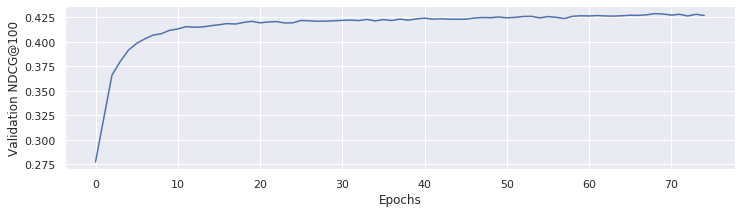

In [44]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass